### Script to process medical CT images 

In [70]:
import os
import numpy as np
import SimpleITK as sitk

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from typing import List, Tuple, Dict, Union 

import pydicom

from matplotlib.animation import FuncAnimation
from PIL import Image
import tempfile
import os



### Processing functions 

In [71]:
#finding directory 
def get_folder_names(exp: str, file_path):
    #Retrieve the names of the folders for the given experiment.
    def list_all_folders(exp_path: str) -> List[str]:
    #List all folders within the experiment path.
        return [f.name for f in os.scandir(exp_path) if f.is_dir()]

    exp_path = os.path.join(file_path, exp)
    folder_names = list_all_folders(exp_path)
    return folder_names, exp_path

#calculating centering points for the image correction 
def calculate_center_points(input_parameters: Dict[str, float]) -> Tuple[List[int], List[int]]:
    """
    Calculate moving center points using given slopes.

    Args:
        input_parameters (Dict[str, float]): Dictionary containing the input parameters.
        num_slices (int): Number of slices.

    Returns:
        Tuple[List[int], List[int]]: Tuple containing lists of x and y center points.
    """
    slope_cx = (input_parameters['cx_in'] - input_parameters['cx_out']) / (input_parameters['num_slices'] - 1)
    Intpt_cx = input_parameters['cx_out'] - slope_cx
    slope_cy = (input_parameters['cy_in'] - input_parameters['cy_out']) / (input_parameters['num_slices'] - 1)
    Intpt_cy = input_parameters['cy_out'] - slope_cy

    cx = [round(slope_cx * i + Intpt_cx) for i in range(1, input_parameters['num_slices'] + 1)]
    cy = [round(slope_cy * i + Intpt_cy) for i in range(1, input_parameters['num_slices'] + 1)]
    
    return cx, cy


#load in images and correct for any slope between intial and final scan 
def load_process_scan(path_to_files: List[str], folder_name: List[str], start_slice: int, cx_list: List[int], cy_list: List[int], cr: int) -> Tuple[np.ndarray, List[float]]:
    """
    Process flow scans by reading DICOM files, averaging, masking, reorienting, and calculating CT numbers.

    Args:
        file_paths (List[str]): List of file paths to the DICOM files.
        cx_list (List[int]): List of center x-coordinates.
        cy_list (List[int]): List of center y-coordinates.
        cr (int): Radius for masking.

    Returns:
        Tuple[np.ndarray, List[float]]: Tuple containing the processed 3D image array and slice-averaged CT numbers.
    """
    def read_dicom_file(file_path: str) -> np.ndarray:
        #Read a DICOM file from the given path
        dicom_file = pydicom.dcmread(file_path, force = "True")
        dicom_file.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian  
        return dicom_file.pixel_array.astype(float)

    
    def center_rock_sample(image: np.ndarray, cx: int, cy: int, cr: int) -> np.ndarray:
        #centering correction 
        nr, nc = image.shape
        xx, yy = np.meshgrid(range(1, nr + 1), range(1, nc + 1), indexing='ij')
        c_mask = ((xx - cx) ** 2 + (yy - cy) ** 2 <= cr ** 2)
        dummy = np.ones_like(image)
        dummy *= c_mask
        dummy[dummy == 0] = np.nan
        centered_image = image * dummy
        return centered_image

    #change directory to one of interest 
    os.chdir(os.path.join(path_to_files, folder_name))
    image_names = os.listdir()
    images_to_process = image_names[start_slice:start_slice + input_parameters['num_slices']]

    processed_images = []
    ct_numbers = []
    for kk, file_path in enumerate(reversed(images_to_process)):
        cx, cy = cx_list[kk], cy_list[kk]
        image = read_dicom_file(file_path)
        centered_image = center_rock_sample(image, cx, cy, cr)
        processed_images.append(centered_image)
        ct_number = np.nanmean(centered_image)
        ct_numbers.append(ct_number)

    print(folder_name)
    return np.array(processed_images), ct_numbers


### Calculating porosity/saturation 

In [133]:

def apply_coarsening(image: np.ndarray, coarse: int) -> np.ndarray:
    # Reshape the image to apply coarsening
    shape = (image.shape[0] // coarse, coarse, image.shape[1] // coarse, coarse)
    coarsened_image = image.reshape(shape).mean(-1).mean(1)
    return coarsened_image

def calculate_porosity(image_dry: np.ndarray, image_wet: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """

    images_porosity              = (image_wet - image_dry) / (CT_water - CT_air) 
    voxel_porosity_coarsened     = [apply_coarsening(image, coarse) for image in images_porosity]
    slice_averaged_porosity      = [np.nanmean(image) for image in voxel_porosity_coarsened] #ignoring voxels  < 0
    core_averaged_porosity       = np.nanmean(slice_averaged_porosity[rockin:rockout])
    voxel_porosity_coarsened     = np.array(voxel_porosity_coarsened)
    return voxel_porosity_coarsened[rockin:rockout, ...], core_averaged_porosity, slice_averaged_porosity[rockin:rockout] 


def calculate_saturation(image_flow: np.ndarray, image_wet: np.ndarray, porosity_voxels: np.ndarray, porosity: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """


    images_sat              = (image_flow-image_wet) / (CT_air-CT_water) 
    voxel_sat_coarsened     = [apply_coarsening(image, coarse) for image in images_sat]
    voxel_sat_coarsened     = np.array(voxel_sat_coarsened)
    voxel_sat_coarsened     = voxel_sat_coarsened[rockin:rockout, ...] 
    voxel_sat_coarsened[voxel_sat_coarsened < 0] = 0  #values < 0 are assigned as 0 
    slice_averaged_sat      = [np.nanmean(image) for image in voxel_sat_coarsened]
    slice_averaged_sat      = [a / b for a, b in zip(slice_averaged_sat, porosity)]
    voxel_sat_coarsened     = voxel_sat_coarsened/porosity_voxels
    core_averaged_sat       = np.nanmean(slice_averaged_sat)
    print('The average saturation for the core is', core_averaged_sat)
    return voxel_sat_coarsened, core_averaged_sat, slice_averaged_sat


def plot_slice_averaged_profiles(slice_averaged: List[float], label, title) -> None:
    size_slice = 0.0625 
    """
    Plot slice-averaged profiles for porosity and CT numbers.

    Args:
        slice_averaged_porosity (List[float]): Slice-averaged porosity values.
        ct_numbers (List[float]): CT numbers for the slices.
    """
    plt.plot(np.linspace(0, len(slice_averaged)*size_slice, num = len(slice_averaged)), slice_averaged, label=label)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.title(title)
    plt.xlabel("Distance from inlet (cm)")
    plt.ylabel("Gas saturation")


### Analysis functions 

In [73]:

def plot_porosity_vs_dsat(porosity_voxels, sat1, sat2):

    #changes in saturation plotted against porosity 
    dsat = sat1- sat2
    plt.plot(porosity_voxels.flatten(), dsat.flatten(), 'x')
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Porosity')
    plt.ylabel('Change in saturation')
    plt.title('Plot of Porosity vs. Change in Saturation')
    plt.grid(True)  # Optional: Add grid lines to the plot
    plt.show()

    plt.plot(porosity_voxels.flatten(), sat1.flatten(), 'x')
    plt.plot(porosity_voxels.flatten(), sat2.flatten(), 'x')
    plt.title('Porosity vs. Saturation')
    plt.xlabel('Porosity')
    plt.ylabel('Saturation')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

    #standard deviation of voxels vs average saturation for the slice 
    def std_vs_sat(sat):

        slice_averaged_sat      = [np.nanmean(image) for image in sat]
        std_saturation          = [np.nanstd(image) for image in sat]
        plt.plot(slice_averaged_sat, std_saturation,  'x')
        plt.xlabel('Slice averaged sat')
        plt.ylabel('Std saturation')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)  # Optional: Add grid lines to the plot

    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    std_vs_sat(sat1)
    plt.subplot(1, 2, 2)
    std_vs_sat(sat2)
    plt.tight_layout()
    plt.show()



### Interactive viewer

In [74]:

def voxel_map_3D(saturation_voxels, input,  v_min, v_max):
    x= saturation_voxels
    v_min = v_min
    v_max = v_max
    down_sample_rate_widget = IntSlider(min=1, max=5, step=1, value=1, description='Downsample Rate:')
    alpha_widget = FloatSlider(min=0, max=1, step=0.1, value=1, description='Opacity:')
    slice_dim_widget = Dropdown(options=[None, 'x', 'y', 'z', 'segment'], value='segment', description='Slice Dimension:')
    slice_pos_widget = IntSlider(min=0, max=input_parameters['rockout'] - 1, step=1, value=0, description='Slice Position:')
    azimuth_widget = IntSlider(min=0, max=360, step=1, value=51, description='Azimuth:')

    def plot_voxels(down_sample_rate=0, alpha=1.0, slice_dim=None, slice_pos=0, azimuth=90):
        plt.close()
        

        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        x_downsampled = x[::down_sample_rate, ::down_sample_rate, ::down_sample_rate]
        
        if slice_dim is None:
            i, j, k = np.where(x_downsampled >= -np.inf)
            color_data = x_downsampled[i, j, k]
        else:
            if slice_dim == 'x':
                i = np.array([slice_pos] * x_downsampled.shape[1] * x_downsampled.shape[2])
                j, k = np.meshgrid(np.arange(x_downsampled.shape[1]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'y':
                j = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[2])
                i, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'z':
                k = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[1])
                i, j = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[1]))
            elif slice_dim == 'segment':
                i, j, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(round(x_downsampled.shape[1]/1.7)), np.arange(x_downsampled.shape[2]))
            
            i, j, k = i.flatten(), j.flatten(), k.flatten()
            color_data = x_downsampled[i, j, k]
        
        sc = ax.scatter(i, j, k, c=color_data, cmap='viridis', marker='s',  vmin=v_min, vmax=v_max, alpha=alpha)
        
        ax.view_init(azim=azimuth)

        ax.set_xlim([0, x_downsampled.shape[0]])
        ax.set_ylim([0, x_downsampled.shape[1]])
        ax.set_zlim([0, x_downsampled.shape[2]])

        cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
        cbar.set_label("Gas Saturation", rotation=-90, labelpad=15)  # Set the label and rotation
        custom_filename = "E:\\Medical_CT\\" + str(input) + ".png"
        plt.savefig(custom_filename)

    def update(frame, ax):
        if frame < 180:  # Phase 1: rotation
            print(f"Rotating, Frame: {frame}")  # debugging
            azimuth = frame
            plot_voxels(azimuth=azimuth, ax=ax)
        elif frame < 180 + x.shape[0]:  # Phase 2: slicing
            slice_pos = frame - 180
            print(f"Slicing, Frame: {frame}, Slice Position: {slice_pos}")  # debugging
            plot_voxels(slice_dim='x', slice_pos=slice_pos, ax=ax)

    '''
    with tempfile.TemporaryDirectory() as tmpdirname:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ani = FuncAnimation(fig, update, frames=np.arange(0, 180 + x.shape[0]), fargs=(ax,))

        frames = []
        durations = []
        
        for i in range(ani.save_count):
            ani._draw_frame(i)
            frame_path = os.path.join(tmpdirname, f"frame_{i}.png")
            plt.savefig(frame_path)
            frames.append(Image.open(frame_path))
            
            if i < 180:  # rotation phase
                durations.append(150)
            else:  # slicing phase
                durations.append(1000)

        frames[0].save(
            'rotation_and_slice.gif',
            save_all=True,
            append_images=frames[1:],
            loop=0,
            duration=durations,
        )'''
        
    interact(
    plot_voxels,
    down_sample_rate=down_sample_rate_widget,
    alpha=alpha_widget,
    slice_dim=slice_dim_widget,
    slice_pos=slice_pos_widget,
    azimuth = azimuth_widget
    )    

#show voxels above a given value 
def threshold_voxel_map_3D(saturation_voxels, input,  v_min, v_max):
    x= saturation_voxels
    v_min = v_min
    v_max = v_max
    down_sample_rate_widget = IntSlider(min=1, max=5, step=1, value=1, description='Downsample Rate:')
    alpha_widget = FloatSlider(min=0, max=1, step=0.1, value=1, description='Opacity:')
    slice_dim_widget = Dropdown(options=[None, 'x', 'y', 'z', 'segment'], value='segment', description='Slice Dimension:')
    slice_pos_widget = IntSlider(min=0, max=input_parameters['rockout'] - 1, step=1, value=0, description='Slice Position:')
    azimuth_widget = IntSlider(min=0, max=360, step=1, value=51, description='Azimuth:')

    def plot_voxels(down_sample_rate=0, alpha=1.0, slice_dim=None, slice_pos=0, azimuth=90):
        plt.close()
        

        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        x_downsampled = x[::down_sample_rate, ::down_sample_rate, ::down_sample_rate]
        
        if slice_dim is None:
            i, j, k = np.where((x_downsampled >= v_min) & (x_downsampled <= v_max))
            color_data = x_downsampled[i, j, k]
        else:
            if slice_dim == 'x':
                i = np.array([slice_pos] * x_downsampled.shape[1] * x_downsampled.shape[2])
                j, k = np.meshgrid(np.arange(x_downsampled.shape[1]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'y':
                j = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[2])
                i, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'z':
                k = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[1])
                i, j = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[1]))
            elif slice_dim == 'segment':
                i, j, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(round(x_downsampled.shape[1]/1.7)), np.arange(x_downsampled.shape[2]))
            
            i, j, k = i.flatten(), j.flatten(), k.flatten()
            color_data = x_downsampled[i, j, k]
        
        sc = ax.scatter(i, j, k, c=color_data, cmap='viridis', marker='s',  vmin=v_min, vmax=v_max, alpha=alpha)
        
        ax.view_init(azim=azimuth)

        ax.set_xlim([0, x_downsampled.shape[0]])
        ax.set_ylim([0, x_downsampled.shape[1]])
        ax.set_zlim([0, x_downsampled.shape[2]])
        
        cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
        cbar.set_label("Gas Saturation", rotation=-90, labelpad=15)  # Set the label and rotation
        
    
    interact(
    plot_voxels,
    down_sample_rate=down_sample_rate_widget,
    alpha=alpha_widget,
    slice_dim=slice_dim_widget,
    slice_pos=slice_pos_widget,
    azimuth = azimuth_widget
    )    





### Analysis of a data set. 

wet
dry
otway_ca_drain


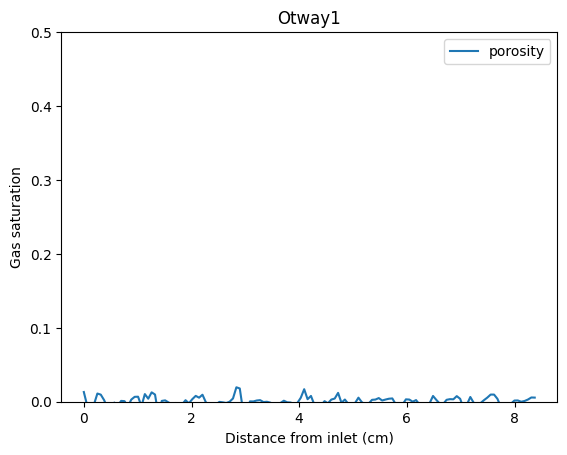

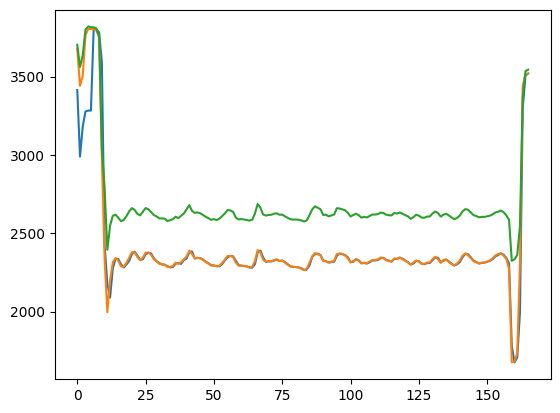

In [118]:
file_path = "E:\\Otway_cores\\"
exp = 'Otway1'

#input parameters such as centering and rock in and rock out are chosen in a separate jupyter notebook 
input_parameters = {
    'CT_water': 0,
    'CT_air': -1000,
    'coarse': 4,
    'rockin': 20,
    'rockout': 154,
    'num_slices': 166,
    'Slicethick': 0.625,
    'Voxsize': 0.1875,
    'cx_in': 255, #centering correction for first slice
    'cy_in': 272,
    'cr': 60, 
    'cx_out': 246, #centering correction for last slice
    'cy_out': 274
}


folder_names, path_to_files = get_folder_names(exp, file_path)
cx_list, cy_list = calculate_center_points(input_parameters)
processed_images_wet, ct_numbers_wet = load_process_scan(path_to_files, "wet", 0, cx_list, cy_list, cr = input_parameters['cr'])
processed_images_dry, ct_numbers_dry = load_process_scan(path_to_files, "dry", 176+16, cx_list, cy_list, cr = input_parameters['cr'])

porosity_voxels, core_averaged_porosity, slice_averaged_porosity = calculate_porosity(processed_images_dry,
                                                                                      processed_images_wet, 
                                                                                      CT_water = input_parameters['CT_water'], 
                                                                                      CT_air = input_parameters['CT_air'], 
                                                                                      coarse = input_parameters['coarse'], 
                                                                                      rockin = input_parameters['rockin'], 
                                                                                      rockout = input_parameters['rockout'])

processed_images_wet2, ct_numbers_wet2 = load_process_scan(path_to_files, "otway_ca_drain", 0, cx_list, cy_list, cr = input_parameters['cr'])


plot_slice_averaged_profiles(slice_averaged_porosity, 'porosity', exp)
plt.show()

#voxel_map_3D(porosity_voxels, 'L2H_postdrain_Bandera', 0.2,  0.4)

plt.plot(ct_numbers_dry)
plt.plot(ct_numbers_wet)
plt.plot(ct_numbers_wet2)




### Capillary dominated drainage fractional flow steps

otway_wet_CF


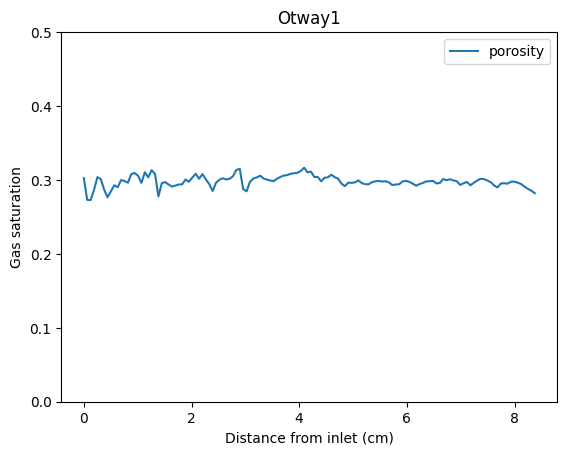

0
otway_Drain_lowf
The average saturation for the core is 0.04232922409010702
528
otway_Drain_lowf
The average saturation for the core is 0.04267464798749407
1056
otway_Drain_lowf
The average saturation for the core is 0.044376199133137645


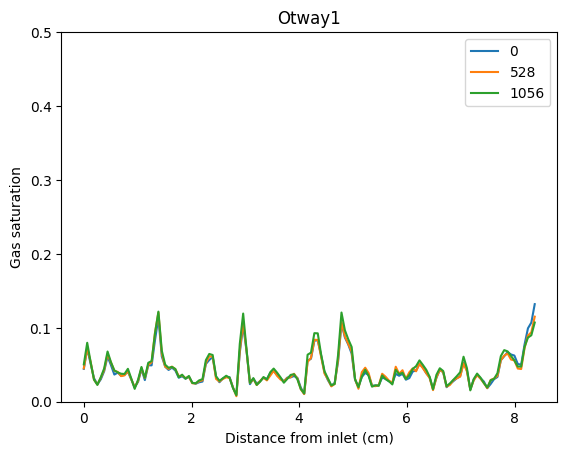

In [157]:

#folder otway_ca_drain contains 7 steps, each with 4 full scans (fw =1 is the wet scan)

fw = [1, 0.95, 0.8, 0.7, 0.5, 0.25, 0.1, 0] #fractional flow steps 

#input parameters such as centering and rock in and rock out are chosen in a separate jupyter notebook 
input_parameters = {
    'CT_water': 0,
    'CT_air': -1000,
    'coarse': 4,
    'rockin': 20,
    'rockout': 154,
    'num_slices': 166,
    'Slicethick': 0.625,
    'Voxsize': 0.1875,
    'cx_in': 248, #centering correction for first slice
    'cy_in': 270,
    'cr': 60, 
    'cx_out': 258, #centering correction for last slice
    'cy_out': 267
}

cx_list, cy_list = calculate_center_points(input_parameters)

processed_images_list = []
saturation_voxels_list = []
slice_averaged_sat_list = []

processed_images_comp, ct_numbers = load_process_scan(path_to_files, "otway_wet_CF", 176, cx_list, cy_list, cr=input_parameters['cr'])
porosity_voxels, core_averaged_porosity, slice_averaged_porosity = calculate_porosity(processed_images_dry,
                                                                                      processed_images_comp, 
                                                                                      CT_water = input_parameters['CT_water'], 
                                                                                      CT_air = input_parameters['CT_air'], 
                                                                                      coarse = input_parameters['coarse'], 
                                                                                      rockin = input_parameters['rockin'], 
                                                                                      rockout = input_parameters['rockout'])


plot_slice_averaged_profiles(slice_averaged_porosity, 'porosity', exp)
plt.show()


for i in range(0, 1584, 528):#, 2112, 2816, 3520, 4224]:
    print(i)
    processed_images, ct_numbers = load_process_scan(path_to_files, "otway_Drain_lowf", i, cx_list, cy_list, cr=input_parameters['cr'])
    saturation_voxels, core_averaged_sat, slice_averaged_sat = calculate_saturation(processed_images, 
                                                                                    processed_images_comp, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air=input_parameters['CT_air'], 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])
    plot_slice_averaged_profiles(slice_averaged_sat, i, exp)
    processed_images_list.append(processed_images)
    saturation_voxels_list.append(saturation_voxels)
    slice_averaged_sat_list.append(slice_averaged_sat)


#saturation_voxels_fw095, saturation_voxels_fw08, saturation_voxels_fw07, saturation_voxels_fw05, saturation_voxels_fw025, saturation_voxels_fw01, saturation_voxels_fw0 = saturation_voxels_list
#slice_averaged_sat_fw095, slice_averaged_sat_fw08, slice_averaged_sat_fw07, slice_averaged_sat_fw05, slice_averaged_sat_fw025, slice_averaged_sat_fw01, slice_averaged_sat_fw0 = slice_averaged_sat_list
plt.show()



interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

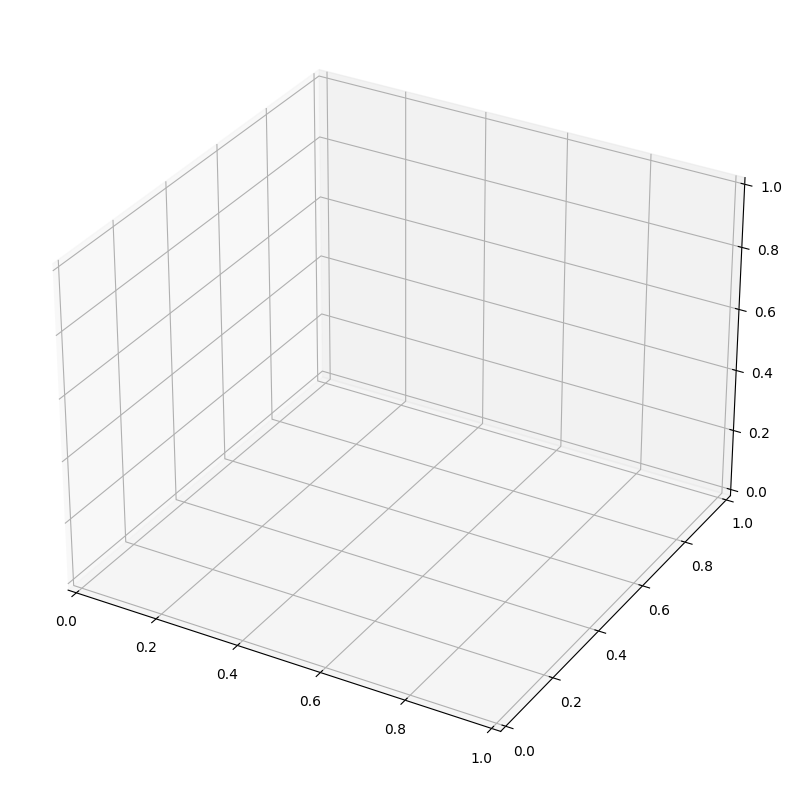

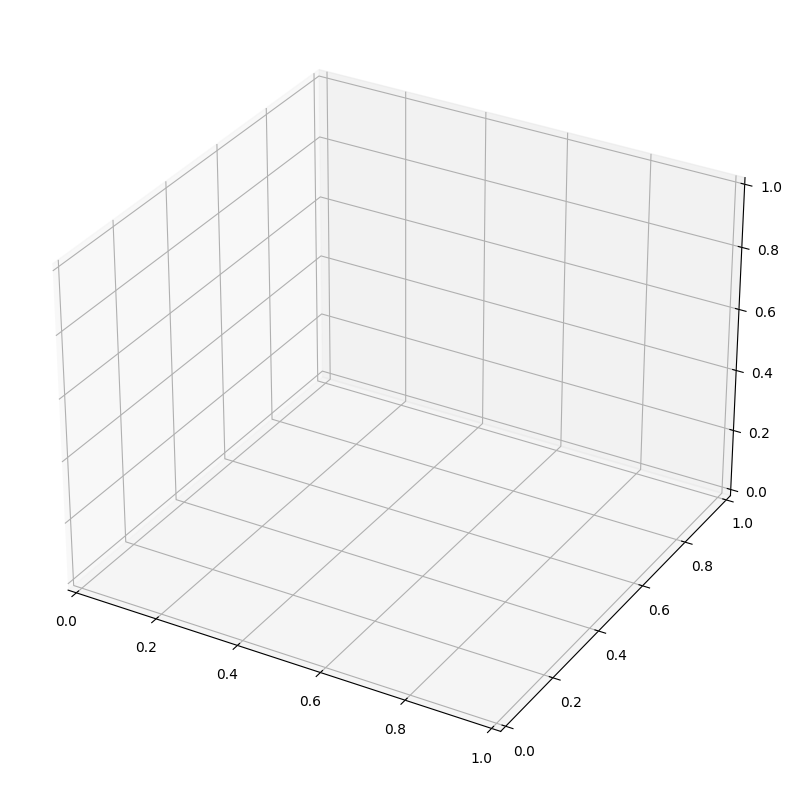

In [156]:
voxel_map_3D(porosity_voxels, 'L2H_postdrain_Bandera',0,  0.4)
plt.show()
voxel_map_3D(saturation_voxels, 'L2H_postdrain_Bandera', 0,  0.5)
plt.show()


otway1_overnight
The average saturation for the core is 0.16860539111996253


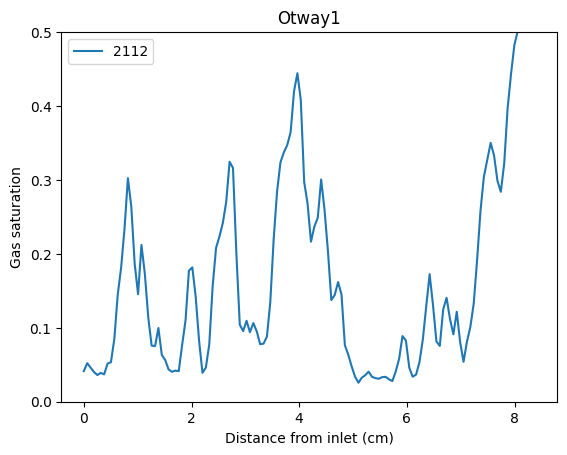

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

In [152]:
for i in [2112]:#, 2112, 2816, 3520, 4224]:
    processed_images, ct_numbers = load_process_scan(path_to_files, "otway1_overnight", i, cx_list, cy_list, cr=input_parameters['cr'])
    saturation_voxels, core_averaged_sat, slice_averaged_sat = calculate_saturation(processed_images, 
                                                                                    processed_images_comp, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air=input_parameters['CT_air'], 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])
    plot_slice_averaged_profiles(slice_averaged_sat, i, exp)
    processed_images_list.append(processed_images)
    saturation_voxels_list.append(saturation_voxels)
    slice_averaged_sat_list.append(slice_averaged_sat)

voxel_map_3D(saturation_voxels, 'L2H_postdrain_Bandera', 0,  0.5)
plt.show()

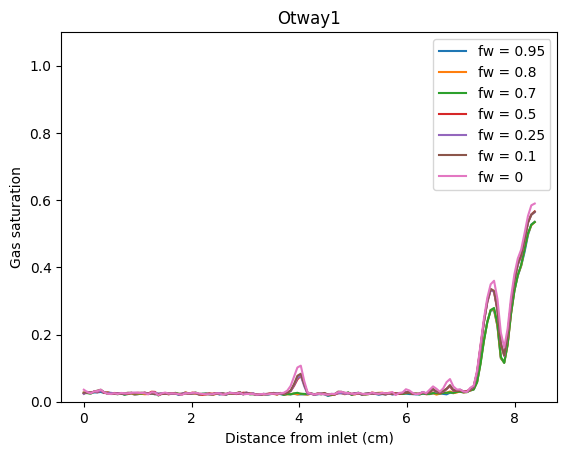

In [129]:
plot_slice_averaged_profiles(slice_averaged_sat_fw095, 'fw = 0.95', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw08,  'fw = 0.8', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw07,  'fw = 0.7', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw05,  'fw = 0.5', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw025, 'fw = 0.25', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw01,  'fw = 0.1', exp)
plot_slice_averaged_profiles(slice_averaged_sat_fw0,   'fw = 0', exp)
plt.ylim(0,1.1)
plt.show()

In [78]:
voxel_map_3D(saturation_voxels_fw0, 'voxel map', -0.1, 0.2)



interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

0.0
0.4406875


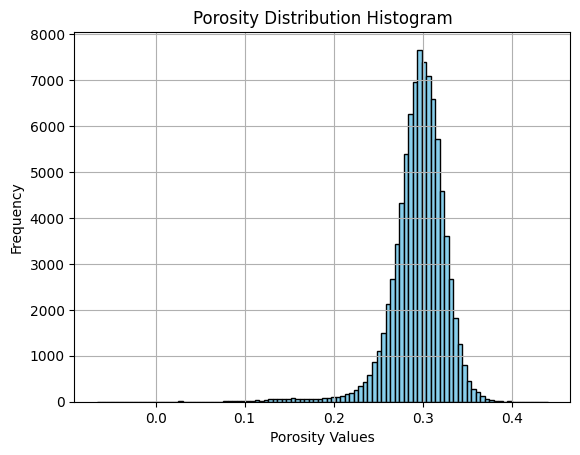

In [79]:
print(np.nanmin(saturation_voxels_fw0))
print(np.nanmax(porosity_voxels))

plt.hist(porosity_voxels.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Porosity Values')
plt.ylabel('Frequency')
plt.title('Porosity Distribution Histogram')
plt.grid(True)
plt.show()

In [101]:
processed_images_list = []
saturation_voxels_list = []
slice_averaged_sat_list = []

processed_images_comp, ct_numbers = load_process_scan(path_to_files, "test_drain", 0, cx_list, cy_list, cr=input_parameters['cr'])

for i in [0, 704, 1408, 2112, 2816, 3520, 4224]:
    processed_images, ct_numbers = load_process_scan(path_to_files, "test_drain", i, cx_list, cy_list, cr=input_parameters['cr'])
    saturation_voxels, core_averaged_sat, slice_averaged_sat = calculate_saturation(processed_images, 
                                                                                    processed_images_comp, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air=input_parameters['CT_air'], 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])
    
    saturation_voxels_list.append(saturation_voxels)
    slice_averaged_sat_list.append(slice_averaged_sat)

saturation_voxels_1, saturation_voxels_2, saturation_voxels_3, saturation_voxels_4, saturation_voxels_5, saturation_voxels_6, saturation_voxels_7 = saturation_voxels_list
slice_averaged_sat_1, slice_averaged_sat_2, slice_averaged_sat_3, slice_averaged_sat_4, slice_averaged_sat_5, slice_averaged_sat_6, slice_averaged_sat_7 = slice_averaged_sat_list



test_drain
test_drain
The average saturation for the core is 0.0
test_drain
The average saturation for the core is 0.021059620056638157
test_drain
The average saturation for the core is 0.021894576737469435
test_drain
The average saturation for the core is 0.022333594907173675
test_drain
The average saturation for the core is 0.02305263898013564
test_drain
The average saturation for the core is 0.02410328828968326
test_drain
The average saturation for the core is 0.024028934404308686


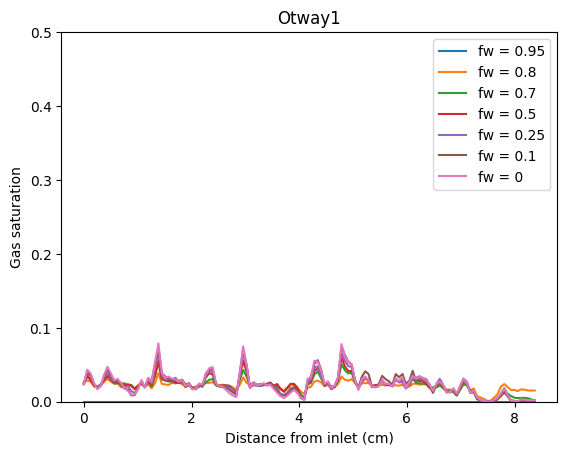

In [102]:
plot_slice_averaged_profiles(slice_averaged_sat_1, 'fw = 0.95', exp)
plot_slice_averaged_profiles(slice_averaged_sat_2,  'fw = 0.8', exp)
plot_slice_averaged_profiles(slice_averaged_sat_3,  'fw = 0.7', exp)
plot_slice_averaged_profiles(slice_averaged_sat_4,  'fw = 0.5', exp)
plot_slice_averaged_profiles(slice_averaged_sat_5, 'fw = 0.25', exp)
plot_slice_averaged_profiles(slice_averaged_sat_6,  'fw = 0.1', exp)
plot_slice_averaged_profiles(slice_averaged_sat_7,   'fw = 0', exp)
plt.ylim(0, 0.5)
plt.show()


In [90]:
voxel_map_3D(saturation_voxels_1, 'test', 0, 0.5)

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

In [83]:
processed_images_list = []
saturation_voxels_list = []
slice_averaged_sat_list = []



for i in [0, 704, 1408, 2112, 2816, 3520, 4224]:
    processed_images, ct_numbers = load_process_scan(path_to_files, "otway_vi_imb", i+528, cx_list, cy_list, cr=input_parameters['cr'])
    saturation_voxels, core_averaged_sat, slice_averaged_sat = calculate_saturation(processed_images, 
                                                                                    processed_images_wet, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air=input_parameters['CT_air'], 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])
    
    processed_images_list.append(processed_images)
    saturation_voxels_list.append(saturation_voxels)
    slice_averaged_sat_list.append(slice_averaged_sat)

saturation_voxels_1, saturation_voxels_2, saturation_voxels_3, saturation_voxels_4, saturation_voxels_5, saturation_voxels_6, saturation_voxels_7 = saturation_voxels_list
slice_averaged_sat_1, slice_averaged_sat_2, slice_averaged_sat_3, slice_averaged_sat_4, slice_averaged_sat_5, slice_averaged_sat_6, slice_averaged_sat_7 = slice_averaged_sat_list



otway_vi_imb
The average saturation for the core is 0.04522525886471846
otway_vi_imb
The average saturation for the core is 0.046996130420626815
otway_vi_imb
The average saturation for the core is 0.04513687942702078
otway_vi_imb
The average saturation for the core is 0.04721318518905809
otway_vi_imb
The average saturation for the core is 0.04569039423899504
otway_vi_imb
The average saturation for the core is 0.042456013849209474
otway_vi_imb
The average saturation for the core is 0.03624274686867296


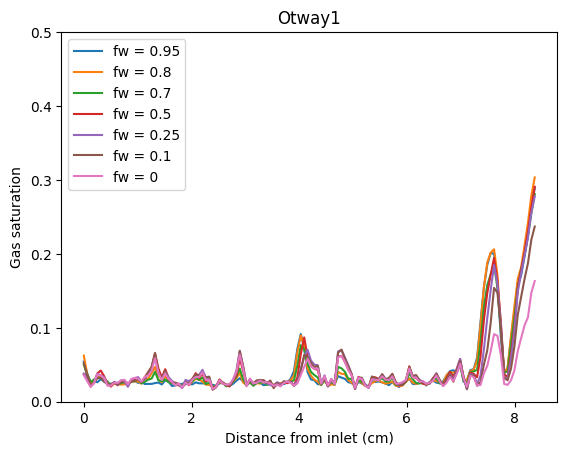

In [84]:
plot_slice_averaged_profiles(slice_averaged_sat_1, 'fw = 0.95', exp)
plot_slice_averaged_profiles(slice_averaged_sat_2,  'fw = 0.8', exp)
plot_slice_averaged_profiles(slice_averaged_sat_3,  'fw = 0.7', exp)
plot_slice_averaged_profiles(slice_averaged_sat_4,  'fw = 0.5', exp)
plot_slice_averaged_profiles(slice_averaged_sat_5, 'fw = 0.25', exp)
plot_slice_averaged_profiles(slice_averaged_sat_6,  'fw = 0.1', exp)
plot_slice_averaged_profiles(slice_averaged_sat_7,   'fw = 0', exp)